# 0. Details that you don't need :p 

* This project aims to detect wether a person is wearing a face mask or not using a convolutional neural network added to a pretrained model which is MobileNetV2.

* This work is done by me khaoula benali and here is my mail : khaoula.benali@ensi-uma.tn .I can't wait for your feedbacks :)

# 1. Importing the necessary libraries :

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
from imutils.video import videostream
import numpy as np
import os
import time
import cv2

# 2. Loading the dataset :

In [2]:
DIRECTORY= r"C:/Users/khaoula/Desktop/Face Mask Detection/dataset"
CATEGORIES=["with_mask","without_mask"]
print("[INFO] loading images...")

[INFO] loading images...


# 3. Data Preprocessing : 

* Labeling images :

In [3]:
data=[]
labels=[]
for category in CATEGORIES:
    path=os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image=load_img(img_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        data.append(image)
        labels.append(category)

C:\Users\khaoula\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


* Encoding the Labels :

In [4]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)


* Converting data into numpy arrays (models only work on numpy arrays)

In [5]:
data=np.array(data,dtype="float32")
labels=np.array(labels)

* Deviding data into training and testing data :

In [6]:
(trainX,testX,trainy,testy)=train_test_split(data,labels,test_size=0.2,stratify=labels,random_state=42)

* That's it for the preprocessing.And now let's start the training.

# 4. Training :

We are going here to use a CNN but instead of the head layer we are going to use the mobilenetv2 and than create a fully connected layer for the top of the model

The model is going to be MobileNetv2 + Fully Connected Model 

* Initializing the learning rate and number of epochs and batch size

In [7]:
INIT_LR=1e-4
EPOCHS=20
BS=32

* Constructing many training images from a single image using ImageDataGenerator :

In [8]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

* Loading the MobileNetV2 Model :

In [9]:
baseModel=MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

* Constructing a fully connected layer that will be placed on the top of the model

In [10]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

* Place the head fully connected model on the top of the base model

In [11]:
model=Model(inputs=baseModel.input,outputs=headModel)

* MobileNetV2 is an already trained models so we need the weights to stay as they are that's why we are going to freeze them that they don't chane when we train the whole model

In [12]:
for layer in baseModel.layers:
    layer.trainable=False

* Compiling the model :

In [13]:
print("[iNFO] compiling model...")
opt=Adam(learning_rate=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=["accuracy"])

[iNFO] compiling model...


* Training the head of the Network :

In [14]:
print("[INFO] ttraining head...")
H=model.fit(aug.flow(trainX,trainy,batch_size=BS),
           steps_per_epoch=len(trainX)//BS,
           validation_data=(testX,testy),
           validation_steps=len(testX)//BS,
           epochs=EPOCHS)

[INFO] ttraining head...
Epoch 1/20
95/95 [==============================] - 141s 1s/step - loss: 0.4085 - accuracy: 0.8734 - val_loss: 0.1506 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 123s 1s/step - loss: 0.1584 - accuracy: 0.9621 - val_loss: 0.0750 - val_accuracy: 0.9922
Epoch 3/20
95/95 [==============================] - 124s 1s/step - loss: 0.1054 - accuracy: 0.9733 - val_loss: 0.0537 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 123s 1s/step - loss: 0.0818 - accuracy: 0.9782 - val_loss: 0.0465 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 120s 1s/step - loss: 0.0687 - accuracy: 0.9819 - val_loss: 0.0440 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 121s 1s/step - loss: 0.0580 - accuracy: 0.9829 - val_loss: 0.0360 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 121s 1s/step - loss: 0.0507 - accuracy: 0.9832 - val_loss: 0.0357 - val_accur

* Testing the model :

In [15]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX,batch_size=BS)

[INFO] evaluating network...


In [16]:
predIdxs=np.argmax(predIdxs,axis=1)

In [17]:
print(classification_report(testy.argmax(axis=1),predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



* Nice results haa? :p ,and now let's save our  model

In [18]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model",save_format="h5")

[INFO] saving mask detector model...


C:\Users\khaoula\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


* Plot the training loss and accuracy :

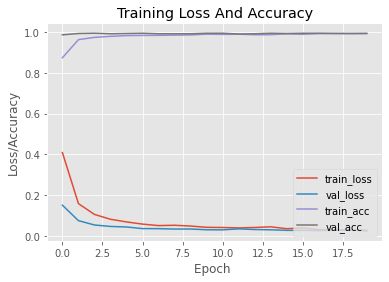

In [19]:
N=EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="val_acc")
plt.title("Training Loss And Accuracy")
plt.xlabel('Epoch ')
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("plot.png")

# 6. Apply the model in camera :

In [20]:
def detect_and_predict_mask(frame,faceNet,maskNet):
    (h,w)=frame.shape[:2]
    blob=cv2.dnn.blobFromImage(frame,1.0,(224,224),(104.0,177.0,123.0))
    faceNet.setInput(blob)
    detections=faceNet.forward()
    print(detections.shape)
    
    faces=[]
    locs=[]
    preds=[]
    for i in range(0,detections.shape[0]):
      confidence=detections[0,0,i,2]
      if confidence>=0.5:
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,starty,endX,endy)=box.astype("int")
        (startX,starty)=(max(0,startX),max(0,starty))
        (endX,endy)=(mmin(w-1,endX),min(h-1,endy))
        face=frame[starty:endy,startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))
        face=img_to_array(face)
        face=preprocess_input(face)
        faces.append(face)
        locs.append((startX, starty, endX, endy))
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
    return (locs, preds)
        

* load our serialized face detector model from disk

In [21]:
prototxtPath = r"C:/Users/khaoula/Desktop/Face Mask Detection/face_detector/deploy.prototxt"
weightsPath = r"C:/Users/khaoula/Desktop/Face Mask Detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

* Load the face mask detector model from disk :

In [22]:
maskNet = load_model("mask_detector.model")

* Initialize the video stream

In [1]:
pip install --upgrade imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=c8c33ce3e121a15bbcaebbfd0ba61e91ef0d86cae9ee86edb552baf93207ee80
  Stored in directory: c:\users\khaoula\appdata\local\pip\cache\wheels\59\1b\52\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
  Attempting uninstall: imutils
    Found existing installation: imutils 0.5.3
    Uninstalling imutils-0.5.3:
      Successfully uninstalled imutils-0.5.3
Note: you may need to restart the kernel to use updated packages.


In [ ]:
print("[INFO] starting video stream...")
from imutils.video import VideoStream
vs = VideoStream().start()
while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
            break
cv2.destroyAllWindows()
vs.stop()